In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian
import scipy.stats as st
# from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-04-14 02:23:05.129206: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Model Training

In [4]:
train = {
    3: {
        'start_time': "2011-04-19",
        'end_time': "2011-05-22"
    },
    2: {
        'start_time': "2011-04-21",
        'end_time': "2011-05-21"
    }
}
test = {
    1: {
        'start_time': "2011-04-28",
        'end_time': "2011-05-15"
    }

}
appliances = ["Microwave"]

In [5]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [6]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [7]:
model = seq2point_gaussian.seq2point()

In [8]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

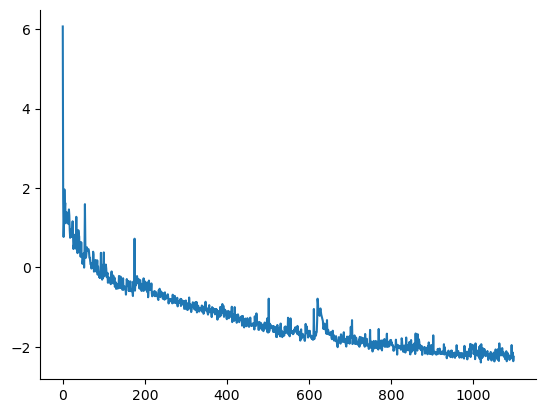

In [9]:
plt.plot(losses)
sns.despine()

In [10]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 10.9 s'

# Before Calibration

##### Results on Calibration Set

In [11]:
%%capture cap
%%time
y_hat = model.apply(params, x_cal, True, rngs={
                    "dropout": jax.random.PRNGKey(0)})

In [12]:
cal_mean = scaler_y.inverse_transform(y_hat[0])
cal_sigma = scaler_y.scale_*y_hat[1]
y_true_cal = scaler_y.inverse_transform(y_cal)

In [13]:
print(f"RMSE : {errors.rmse(y_true_cal, cal_mean):.4f} MAE  : {errors.mae(y_true_cal, cal_mean):.4f} NLL : {errors.NLL(cal_mean,cal_sigma,y_true_cal):.4f}")

RMSE : 92.2513 MAE  : 10.4164 NLL : 2.3873


In [14]:
mlp_calibration_time = cap.stdout.split('\n')[1]
mlp_calibration_time

'Wall time: 1.16 s'

##### Results on Training Set

In [15]:
y_hat_train = model.apply(params, x_train, True, rngs={
    "dropout": jax.random.PRNGKey(0)})

In [16]:
train_mean = scaler_y.inverse_transform(y_hat_train[0])
train_sigma = scaler_y.scale_*y_hat_train[1]
y_train_scaled = scaler_y.inverse_transform(y_train)

In [17]:
print(f"RMSE : {errors.rmse(y_train_scaled, train_mean):.4f} MAE  : {errors.mae(y_train_scaled, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_train_scaled):.4f}")

RMSE : 89.6215 MAE  : 10.0386 NLL : 2.2867


##### Results on Test Set

In [18]:
%%capture cap
%%time
y_hat_test = model.apply(params, x_test, True, rngs={
    "dropout": jax.random.PRNGKey(0)})

In [19]:
test_mean = scaler_y.inverse_transform(y_hat_test[0])
test_sigma = scaler_y.scale_*y_hat_test[1]

In [20]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test, test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 104.4222 MAE  : 11.8118 NLL : 55.4056


In [21]:
mlp_testing_time = cap.stdout.split('\n')[1]
mlp_testing_time

'Wall time: 1 s'

# After Calibration

### Isotonic Regression

In [22]:
def ace(ideal, predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y, yhat):
        return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss, in_axes=(0, 0))(ideal, predicted))

In [23]:
%%capture cap
%%time
series_train = find_p_hat(y_train_scaled, train_mean, train_sigma)
series_test = find_p_hat(y_test, test_mean, test_sigma)
series_cal = find_p_hat(y_true_cal, cal_mean, cal_sigma)

In [24]:
isotonic_1 = cap.stdout.split('\n')[1]
isotonic_1

'Wall time: 637 ms'

In [25]:
%%capture cap
%%time
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(series_cal.values, series_cal.index)

In [26]:
isotonic_2 = cap.stdout.split('\n')[1]
isotonic_2

'Wall time: 1.4 ms'

In [27]:
%%capture cap
%%time
p = series_cal.index
new_p = calibrator.predict(series_cal.index)

In [28]:
isotonic_3 = cap.stdout.split('\n')[1]
isotonic_3

'Wall time: 289 us'

In [29]:
%%capture cap
%%time
new_p_hat_train = find_new_p_hat(
    y_train_scaled, new_p, train_mean, train_sigma)
new_p_hat_cal = find_new_p_hat(y_true_cal, new_p, cal_mean, cal_sigma)
new_p_hat_test = find_new_p_hat(y_test, new_p, test_mean, test_sigma)

In [30]:
isotonic_4 = cap.stdout.split('\n')[1]
isotonic_4

'Wall time: 49.9 ms'

In [31]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

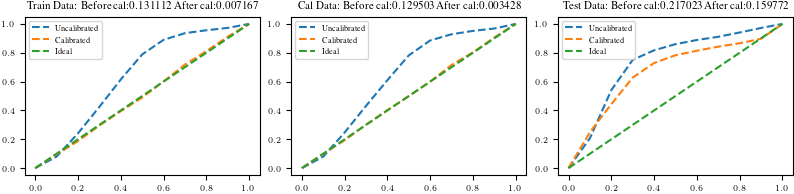

In [32]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (8, 2)})
plt.subplot(1, 3, 1)
plt.plot(p, series_train.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(p, series_cal.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Cal Data: Before cal:{ace(p.values,series_cal.values):2f} After cal:{ace(p.values,new_p_hat_cal):2f}")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(p, series_test.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Test Data: Before cal:{ace(p.values,series_test.values):2f} After cal:{ace(p.values,new_p_hat_test):2f}")
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero.pdf')